In [1]:
import gym
import time
import torch
import matplotlib.pyplot as plt

from gym.envs.registration import register
register(
    id='FrozenLakeNotSlippery-v0',
    entry_point='gym.envs.toy_text:FrozenLakeEnv',
    kwargs={'map_name': '4x4', 'is_slippery': False},
)

## Q-learning
First off applying the most well-known _tabular_, _one-step_ TD method originally introduced by [(Watkins, 1989)](https://www.gatsby.ucl.ac.uk/~dayan/papers/cjch.pdf). Which learns the $Q$ function using bootstrapping, the update rule is defined as,

\begin{align}
Q_t(s, a) &= Q_{t-1}(s, a) - a \cdot \text{TD} \\
&= Q(s, a)+\alpha \left[r+\gamma * \max _{a^{\prime}} Q\left(s^{\prime}, a^{\prime}\right)-Q(s, a)\right] \\
&=(1-\alpha) Q(s, a)+\alpha \left[r+\gamma * \max _{a^{\prime}} Q\left(s^{\prime}, a^{\prime}\right)\right]
\end{align}

### Q-learning in a deterministic environment

Also named off-policy TD control for estimating the policy, can be found in chapter 6.5 by Barto & Sutton. The reason that Q-learning is off-policy is that it updates its Q-values using the Q-value of the next state 𝑠′ and the greedy action 𝑎′. In other words, it estimates the return (total discounted future reward) for state-action pairs assuming a greedy policy were followed despite the fact that it's not following a greedy policy.

# <img src="../img/Q-learning_CH6.5.png">

In [35]:
def print_statistics(Q, rewards_total, num_episodes, eps_decay=None, Q_2=None):
    if Q_2 is not None:
        print("Q_1:", Q)
        print("Q_2:", Q_2)
    else:
        print(Q)
        
    print("Percentage of episodes finished succesfully: {0}".format(
        sum(rewards_total)/num_episodes))
    print("Percentage of episodes finished succesfully (last 100 episodes): {0}".format(
        sum(rewards_total[-100:])/100))

    print("Average number of steps: %.2f" % (sum(steps_total)/num_episodes))
    print("Average number of steps (last 100 episodes): %.2f" % (sum(steps_total[-100:])/100))


    plt.figure(figsize=(12, 5))
    plt.title("Rewards")
    plt.bar(torch.arange(len(rewards_total)), rewards_total, alpha=0.6, color='green')
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.title("Steps")
    plt.bar(torch.arange(len(steps_total)), steps_total, alpha=0.6, color='red')
    plt.show()
    
    if eps_decay is not None:
        plt.figure(figsize=(12, 5))
        plt.title("$epsilon$-greedy values")
        plt.bar(torch.arange(len(egreedy_total)), egreedy_total, alpha=0.6, color='blue')
        plt.show()

Episode finished after 2 steps
Episode finished after 9 steps
Episode finished after 8 steps
Episode finished after 6 steps
Episode finished after 6 steps
Episode finished after 6 steps
Episode finished after 6 steps
Episode finished after 6 steps
Episode finished after 6 steps
Episode finished after 6 steps
tensor([[0.0000, 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.7782, 0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000]])
Percentage of epi

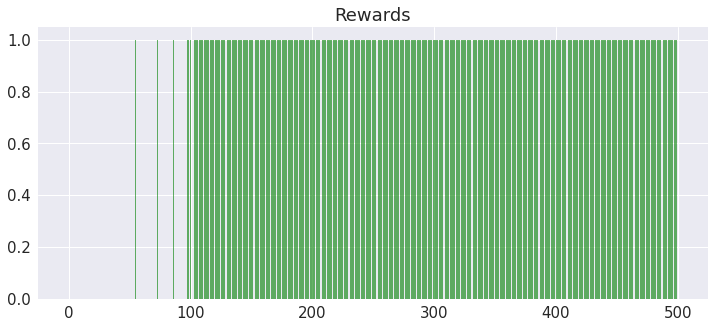

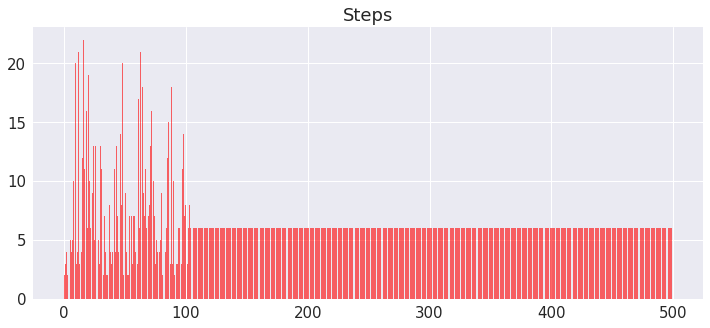

In [21]:
env = gym.make('FrozenLakeNotSlippery-v0')
number_of_states = env.observation_space.n
number_of_actions = env.action_space.n

rewards_total = []
steps_total = []


# Hyperparameters
num_episodes = 500
gamma = 1
alpha = 0.8

# Q-estimate
Q = torch.zeros([number_of_states, number_of_actions])

# Loop for each episode
for i in range(num_episodes):
    # Initiatize S
    observation = env.reset()
    steps = 0
    
    while True:
        steps += 1

        # Choose next A from S using policy derived from Q
        # Adding randomness to explore
        random_values = Q[observation] + torch.randn(1, number_of_actions)/1000
        action = torch.argmax(random_values).item()
        
        # Take action A, observce R, S'
        new_observation, reward, done, info = env.step(action)

        # Q(S, A) <- Q(S, A) + alpha[R + gamma max_a(S', a) - Q(S, A)]
        Q[observation, action] += alpha * (reward + gamma * 
                                           torch.max(Q[new_observation]).item() - Q[observation, action])

        # S <- S'
        observation = new_observation        
        
        # Terminate if environment is done
        if done:
            # Store statistics
            steps_total.append(steps)
            rewards_total.append(reward)
            if i % 50 == 0:
                print("Episode finished after %i steps" % steps)
            break

print_statistics(Q, rewards_total, num_episodes)

### Q-Learning in stochastic environment

This shows how much harder the environment gets if it becomes stochastic, e.g. there is a chance for the agent to slip into a hole in the environment.

Episode finished after 5 steps
Episode finished after 3 steps
Episode finished after 2 steps
Episode finished after 7 steps
Episode finished after 21 steps
Episode finished after 7 steps
Episode finished after 44 steps
Episode finished after 38 steps
Episode finished after 100 steps
Episode finished after 100 steps
Episode finished after 38 steps
Episode finished after 40 steps
Episode finished after 12 steps
Episode finished after 32 steps
Episode finished after 14 steps
Episode finished after 100 steps
Episode finished after 99 steps
Episode finished after 21 steps
Episode finished after 51 steps
Episode finished after 8 steps
Episode finished after 99 steps
Episode finished after 39 steps
Episode finished after 60 steps
Episode finished after 47 steps
Episode finished after 15 steps
Episode finished after 62 steps
Episode finished after 34 steps
Episode finished after 27 steps
Episode finished after 90 steps
Episode finished after 11 steps
Episode finished after 17 steps
Episode fin

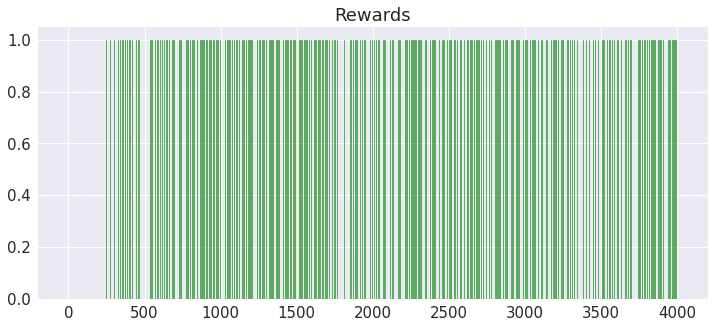

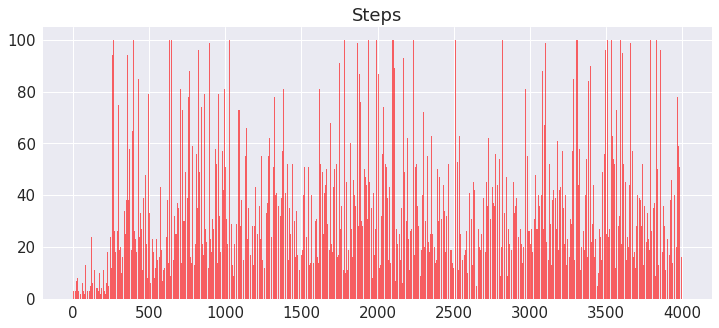

In [20]:
env = gym.make('FrozenLake-v0')
number_of_states = env.observation_space.n
number_of_actions = env.action_space.n

rewards_total = []
steps_total = []

# Hyperparameters
num_episodes = 4000
gamma = 0.95
alpha = 0.85

Q = torch.zeros([number_of_states, number_of_actions])

# Loop for each episode
for i in range(num_episodes):
    # Initiatize S
    observation = env.reset()
    steps = 0
    
    while True:
        steps += 1

        # Choose next A from S using policy derived from Q
        # Adding randomness to explore
        random_values = Q[observation] + torch.randn(1, number_of_actions)/1000
        action = torch.argmax(random_values).item()
        
        # Take action A, observce R, S'
        new_observation, reward, done, info = env.step(action)

        # Q(S, A) <- Q(S, A) + alpha[R + gamma max_a(S', a) - Q(S, A)]
        Q[observation, action] = (1-alpha) * Q[observation, action] + alpha * (
            reward + gamma * torch.max(Q[new_observation]).item())

        # S <- S'
        observation = new_observation        
        
        # Terminate if environment is done
        if done:
            # Store statistics
            steps_total.append(steps)
            rewards_total.append(reward)            
            if i % 50 == 0:
                print("Episode finished after %i steps" % steps)
            break
            

print_statistics(Q, rewards_total, num_episodes)

### Q-Learning in deterministic environment
Now applying a exploration technique to keep exploring the environment, $\epsilon$-greedy,

\begin{align}
a=\left\{\begin{array}{ll}\text {optimal } a^{*} & 1-\varepsilon \\ \text {random} & \varepsilon\end{array}\right.
\end{align}

As we now keep exploring, we will sometimes not terminate all episodes succesfully. 

Episode finished after 13 steps
Episode finished after 2 steps
Episode finished after 6 steps
Episode finished after 8 steps
Episode finished after 6 steps
Episode finished after 4 steps
Episode finished after 6 steps
Episode finished after 8 steps
Episode finished after 6 steps
Episode finished after 6 steps
Episode finished after 6 steps
Episode finished after 6 steps
Episode finished after 8 steps
Episode finished after 7 steps
Episode finished after 6 steps
Episode finished after 6 steps
Episode finished after 6 steps
Episode finished after 6 steps
Episode finished after 6 steps
Episode finished after 6 steps
tensor([[0.7351, 0.7738, 0.6983, 0.7351],
        [0.7351, 0.0000, 0.0000, 0.0000],
        [0.5237, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.7738, 0.8145, 0.0000, 0.7351],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.8145, 0.0000, 0.8574, 0.7738],
 

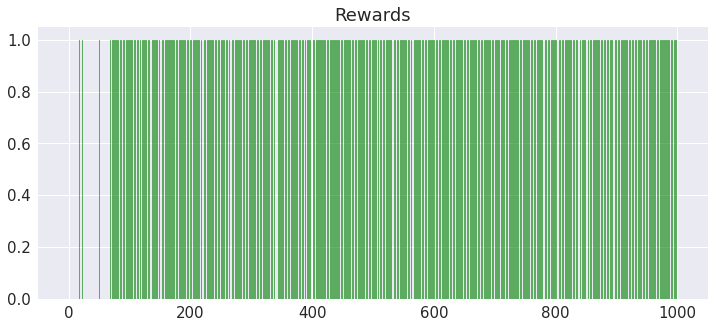

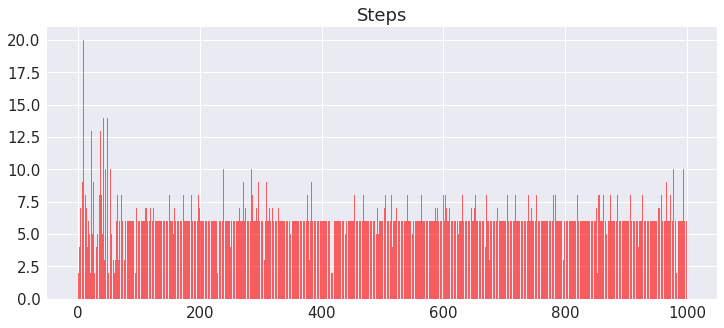

In [30]:
env = gym.make('FrozenLakeNotSlippery-v0')
number_of_states = env.observation_space.n
number_of_actions = env.action_space.n

rewards_total = []
steps_total = []

# Hyperparameters
num_episodes = 1000
gamma = 0.95
alpha = 0.75
epsilon = 0.05

Q = torch.zeros([number_of_states, number_of_actions])

# Loop for each episode
for i in range(num_episodes):
    # Initiatize S
    observation = env.reset()
    steps = 0
    
    while True:
        steps += 1

        # Choose next A from S using policy derived from Q,
        # Using an epsilon-greedy technique
        random_val = torch.rand(1)[0].item()
        if random_val > epsilon:
            random_values = Q[observation] + torch.randn(1, number_of_actions)/1000
            action = torch.argmax(random_values).item()
        else:
            action = env.action_space.sample()
        
        
        # Take action A, observce R, S'
        new_observation, reward, done, info = env.step(action)

        # Q(S, A) <- Q(S, A) + alpha[R + gamma max_a(S', a) - Q(S, A)]
        Q[observation, action] += alpha * (reward + gamma * torch.max(
            Q[new_observation]).item() - Q[observation, action])

        # S <- S'
        observation = new_observation        
        
        # Terminate if environment is done
        if done:
            # Store statistics
            steps_total.append(steps)
            rewards_total.append(reward)
            if i % 50 == 0:
                print("Episode finished after %i steps" % steps)
            break
            

print_statistics(Q, rewards_total, num_episodes)

We will now, adjust our exploration function by introducing $\epsilon$-greedy with decay, to reduce the exploration the more episodes have been finished as the environment is sufficiently explored.

Episode finished after 9 steps
Episode finished after 3 steps
Episode finished after 4 steps
Episode finished after 6 steps
Episode finished after 6 steps
Episode finished after 6 steps
Episode finished after 7 steps
Episode finished after 6 steps
Episode finished after 8 steps
Episode finished after 6 steps
Episode finished after 7 steps
Episode finished after 8 steps
Episode finished after 6 steps
Episode finished after 7 steps
Episode finished after 6 steps
Episode finished after 6 steps
Episode finished after 7 steps
Episode finished after 6 steps
Episode finished after 6 steps
Episode finished after 6 steps
tensor([[0.7351, 0.7738, 0.6983, 0.7351],
        [0.7351, 0.0000, 0.5750, 0.6927],
        [0.0000, 0.8306, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.7738, 0.8145, 0.0000, 0.7351],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.9025, 0.0000, 0.3950],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.8145, 0.0000, 0.8574, 0.7738],
  

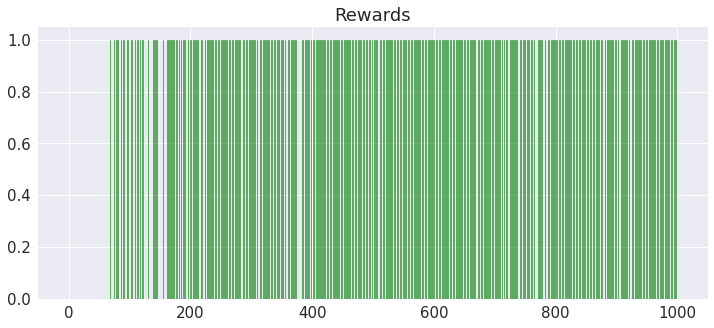

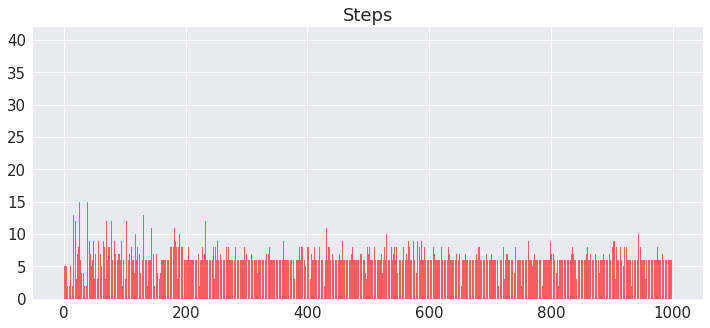

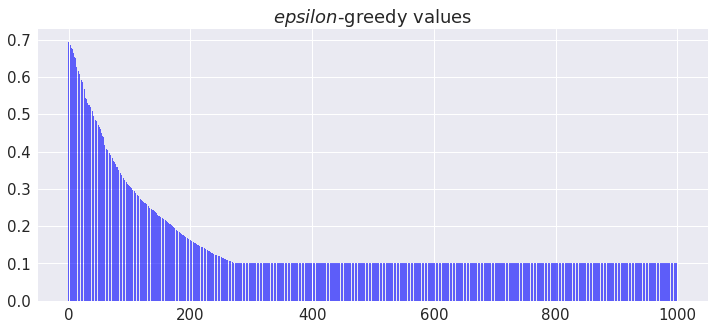

In [34]:
env = gym.make('FrozenLakeNotSlippery-v0')
number_of_states = env.observation_space.n
number_of_actions = env.action_space.n

rewards_total = []
steps_total = []
egreedy_total = []

# Hyperparameters
num_episodes = 1000
gamma = 0.95
alpha = 0.80

epsilon = 0.7
epsilon_final = 0.1
epsilon_decay = 0.999

Q = torch.zeros([number_of_states, number_of_actions])

# Loop for each episode
for i in range(num_episodes):
    # Initiatize S
    observation = env.reset()
    steps = 0
    
    while True:
        steps += 1

        # Choose next A from S using policy derived from Q,
        # Using an epsilon-greedy technique
        random_val = torch.rand(1)[0].item()
        if random_val > epsilon:
            random_values = Q[observation] + torch.randn(1, number_of_actions)/1000
            action = torch.argmax(random_values).item()
        else:
            action = env.action_space.sample()
        
        if epsilon > epsilon_final:
            epsilon *= epsilon_decay
        
        # Take action A, observce R, S'
        new_observation, reward, done, info = env.step(action)

        # Q(S, A) <- Q(S, A) + alpha[R + gamma max_a(S', a) - Q(S, A)]
        Q[observation, action] += alpha * (reward + gamma * torch.max(
            Q[new_observation]).item() - Q[observation, action])

        # S <- S'
        observation = new_observation
        
        # Terminate if environment is done
        if done:
            # Store statistics
            egreedy_total.append(epsilon)
            steps_total.append(steps)
            rewards_total.append(reward)
            if i % 50 == 0:
                print("Episode finished after %i steps" % steps)
            break
            

print_statistics(Q, rewards_total, num_episodes, egreedy_total)

### Double Q-Learning
Due to the maximum operator in the TD update of Q-learning, a _maximization bias_ is induced. In other words, due to always considering the maximum state we will always overestimate the value of an action resulting in a positive bias. Hence, the introduction of _double Q-learning_, using two independent estimators to determine the maximizing action $A^* = \arg \max_a Q_1(a)$, and the other, $Q_2$, to provide the estimate of its value $Q_2(A^*) = Q_2(\arg max_a Q_1(a))$. This estimate will then be unbiased in the sense that $\mathbb{E}\left[Q_{2}\left(A^{*}\right)\right]=q\left(A^{*}\right)$.

# <img src="../img/deep-Q-learning_CH6.7.png">

Episode finished after 3 steps
Episode finished after 11 steps
Episode finished after 16 steps
Episode finished after 14 steps
Episode finished after 9 steps
Episode finished after 9 steps
Episode finished after 7 steps
Episode finished after 6 steps
Episode finished after 6 steps
Episode finished after 6 steps
Episode finished after 4 steps
Episode finished after 6 steps
Episode finished after 6 steps
Episode finished after 5 steps
Episode finished after 6 steps
Episode finished after 10 steps
Episode finished after 6 steps
Episode finished after 8 steps
Episode finished after 5 steps
Episode finished after 6 steps
Q_1: tensor([[0.7351, 0.6983, 0.7738, 0.7351],
        [0.7351, 0.0000, 0.8145, 0.7738],
        [0.7738, 0.8574, 0.7738, 0.8145],
        [0.8145, 0.0000, 0.6584, 0.0000],
        [0.0000, 0.8141, 0.0000, 0.7351],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.9025, 0.0000, 0.8145],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.8567, 0.

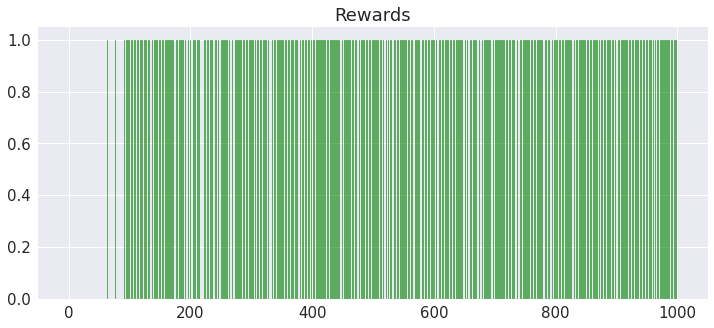

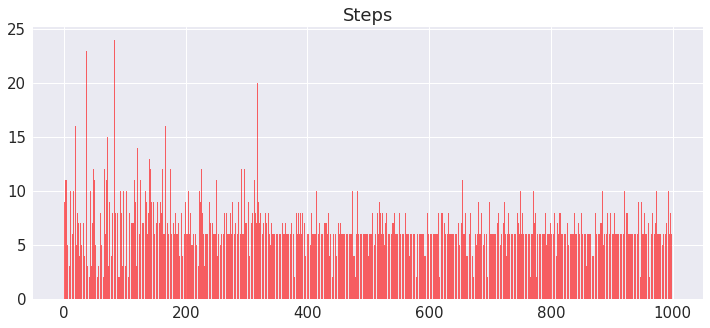

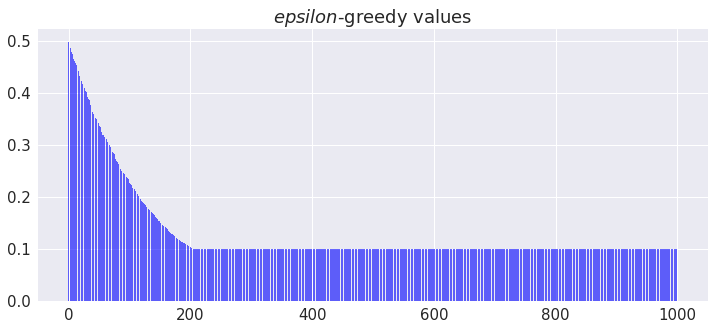

In [57]:
env = gym.make('FrozenLakeNotSlippery-v0')
number_of_states = env.observation_space.n
number_of_actions = env.action_space.n

rewards_total = []
steps_total = []
egreedy_total = []


# Hyperparameters
num_episodes = 1000
gamma = 0.95
alpha = 0.95

epsilon = 0.5
epsilon_final = 0.1
epsilon_decay = 0.999

# Bernoulli trials to decide estimators
bernoulli_trial = lambda : int(torch.bernoulli(torch.Tensor([0.5])).item()) == 1
Q1 = torch.zeros([number_of_states, number_of_actions])
Q2 = torch.zeros([number_of_states, number_of_actions])

# Loop for each episode
for i in range(num_episodes):
    # Initiatize S
    observation = env.reset()
    steps = 0
    
    while True:
        steps += 1
        bernoulli_result = bernoulli_trial()

        # Choose next A from S using policy derived from Q,
        # Using an epsilon-greedy technique
        random_val = torch.rand(1)[0].item()
        if random_val > epsilon:
            if bernoulli_result:
                random_values = Q1[observation] + torch.randn(1, number_of_actions)/1000
                action = torch.argmax(random_values).item()
            else:
                random_values = Q2[observation] + torch.randn(1, number_of_actions)/1000
                action = torch.argmax(random_values).item()
        else:
            action = env.action_space.sample()

        if epsilon > epsilon_final:
            epsilon *= epsilon_decay
                
        # Take action A, observce R, S'
        new_observation, reward, done, info = env.step(action)
        
        # With 0.5 probability,
        if bernoulli_result:
            # Q_1(S, A) <- Q_1(S, A) + alpha[R + gamma Q_2(max_a(S', a)) - Q_1(S, A)]
            Q1[observation, action] += alpha * (reward + gamma * torch.max(
                Q2[new_observation]).item() - Q1[observation, action])
        else:
            # Q_2(S, A) <- Q_2(S, A) + alpha[R + gamma Q_1(max_a(S', a)) - Q_2(S, A)]
            Q2[observation, action] += alpha * (reward + gamma * torch.max(
                Q1[new_observation]).item() - Q2[observation, action])
        
        # S <- S'
        observation = new_observation
        
        # Terminate if environment is done
        if done:
            # Store statistics
            egreedy_total.append(epsilon)
            steps_total.append(steps)
            rewards_total.append(reward)
            if i % 50 == 0:
                print("Episode finished after %i steps" % steps)
            break
            

print_statistics(Q1, rewards_total, num_episodes, egreedy_total, Q2)